In [1]:
import pandas as pd

import numpy as np
import sys, os
from scipy import stats
import collections
import math
import statistics
import re

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib

matplotlib.rcParams['xtick.major.size'] = 8
matplotlib.rcParams['xtick.major.width'] = 2.5
matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['xtick.minor.size'] = 4
matplotlib.rcParams['xtick.minor.width'] = 1
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = 'Arial'

In [2]:
# function to change boxplot width
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        # change the bar width
        patch.set_width(new_value)
        # recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

## Figure 2A: Location and usage frequency of donors

In [3]:
# import splicing data
hela = pd.read_csv('ptreseq_splicing_quantification/HELA_2rep_fraction.txt', sep = '\t')

# convert to long form
hela = pd.melt(
    hela, 
    id_vars = 'RE', 
    value_vars = hela.columns[1:-1],
    var_name = 'isoform',
    value_name = 'fraction'
)

# rename donor to GFP, alt-GFP, PRE, or others
def rename_donor(isoform):
    if isoform == 'full_length':
        return np.nan, np.nan
    elif 'GTACAA_132' in isoform:
        return 'GFP', 132
    elif 'CGAGCT_126' in isoform:
        return 'alt-GFP', 126
    elif 'CGACTT_171' in isoform:
        return 'PRE', 171
    elif 'CGACTT_204' in isoform:
        return 'PRE', 204
    else:
        return 'others', float(isoform.split('_')[1])

hela['donor_name'], hela['donor_pos'] = zip(*hela['isoform'].apply(lambda g: rename_donor(g)))

In [4]:
# For each reporter, group together the same donor and add the splicing fraction to get donor usage
grouped_donor = hela.groupby(['donor_name', 'donor_pos'])['fraction'].sum().reset_index()

min_idx = 0
max_idx = 350 # end of barcode position

for i in range(min_idx, max_idx):
    if float(i) not in grouped_donor['donor_pos'].to_list():
        grouped_donor = grouped_donor.append(
            {'donor_name': 'n/a', 'donor_pos': i, 'fraction': 0}, ignore_index = True
        )

grouped_donor = grouped_donor.sort_values(by = 'donor_pos')

# list of colors
color_dict = {'GFP': 'green', 'PRE': 'yellow', 'alt-GFP': 'blue', 'others': 'grey', 'n/a': 'grey'}
grouped_donor['color'] = grouped_donor['donor_name'].apply(lambda g: color_dict[g])

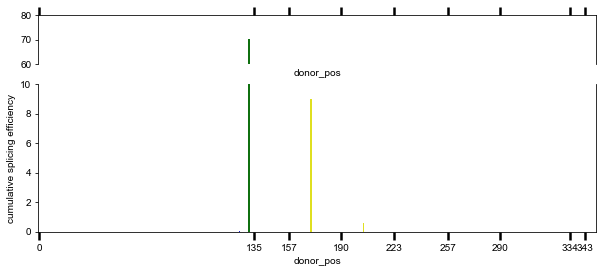

In [6]:
# Barplot with broken y axis
f, (ax1, ax2) = plt.subplots(
    nrows = 2, 
    figsize = (10, 4), 
    sharex = True, 
    gridspec_kw={'height_ratios': [1, 3]}
)

sns.barplot(
    data = grouped_donor, 
    x = 'donor_pos', 
    y = 'fraction', 
    palette = grouped_donor['color'],
    ax = ax1
)

sns.barplot(
    data = grouped_donor, 
    x = 'donor_pos', 
    y = 'fraction', 
    palette = grouped_donor['color'],
    ax = ax2
)

ax1.set_ylabel('')
ax2.set_ylabel('cumulative splicing efficiency')

ax1.set_ylim(60, 80)
ax2.set_ylim(-0.05, 10)

ax2.set_xticks([0, 135, 157, 190, 223, 257, 290, 334, 343])
ax2.set_xticklabels([0, 135, 157, 190, 223, 257, 290, 334, 343])

# hide the spines between ax and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

#f.savefig('Figures_ver3/Figure_2A_donor_position.pdf', transparent = True)

## Figure 2B: PTRE-seq donors compared to human annotated donors

In [34]:
# Retrieve MaxEnt score for all human splice donor
fns = ['human_CDS_5ss_MAXENT.txt', 'human_3UTR_5ss_MAXENT.txt', 'human_5UTR_5ss_MAXENT.txt']
scores = []

for fn in fns:
    with open(f'data/{fn}', 'r') as f:
        for line in f:
            if 'MAXENT' in line:
                spl = line.rstrip().split(' ')
                score = float(spl[1])
                scores.append(score)

(-10.0, 13.0)

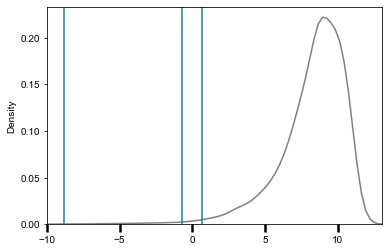

In [35]:
f, ax = plt.subplots()

sns.kdeplot(x = scores, ax = ax, color = 'grey', bw_adjust = 3)

ax.axvline(0.66) # GFP donor maxent score
ax.axvline(-0.73) # PRE donor maxent score
ax.axvline(-8.82) # alt-GFP donor maxent score

ax.set_xlim(-10, 13)

#f.savefig('Figures_ver3/MAXENT_score_all_SD_transcriptome.pdf', transparent = True)

## Figure 2D: Location and usage frequency of acceptors

In [7]:
def get_acceptor_loc(RE, isoform):
    
    if isoform == 'full_length':
        return np.nan, np.nan
    else:
        spl = isoform.split('_')
        loc = float(spl[3])
        acc = 'other'
        
        if len(RE) == 4 and RE != 'Dna2':
            if 157 < loc < 190:
                acc = RE[0]
            elif 190 < loc < 223:
                acc = RE[1]
            elif 223 < loc < 256:
                acc = RE[2]
            elif 256 < loc < 290:
                acc = RE[3]
            elif 290 < loc < 334:
                acc = 'spacer'
            
        return acc, loc
    
        
hela['acceptor_name'], hela['acceptor_pos'] = zip(*hela.apply(
    lambda g: get_acceptor_loc(g['RE'], g['isoform']), axis = 1)
                                                 )

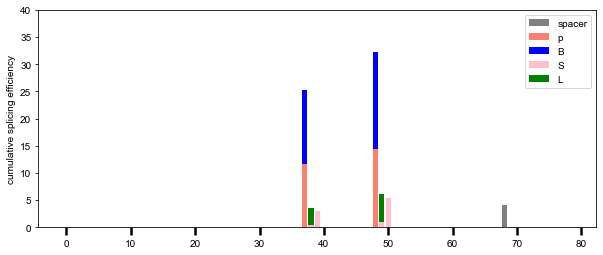

In [9]:
# plot acceptor usage as stacked barplot

f, ax = plt.subplots(figsize = (10, 4))

min_idx = 115
max_idx = 352 # end of barcode position
grouped_acceptor = hela.groupby(['acceptor_name', 'acceptor_pos'])['fraction'].sum().reset_index()
bottom = np.array([0.0]*79)

for acceptor, color in zip(['spacer', 'p', 'B', 'S', 'L'], ['grey', 'salmon', 'blue', 'pink', 'green']):
    _grouped_acceptor = grouped_acceptor[grouped_acceptor['acceptor_name']==acceptor]

    for i in range(min_idx, max_idx):
        if float(i) not in _grouped_acceptor['acceptor_pos'].to_list():
            _grouped_acceptor = _grouped_acceptor.append(
                {'acceptor_name': 'n/a', 'acceptor_pos': i, 'fraction': 0}, ignore_index = True
            )
            
    _grouped_acceptor = _grouped_acceptor.sort_values(by = 'acceptor_pos')   
    
    _grouped_acceptor['new_idx'] = [i for i in range(int(len(_grouped_acceptor)/3)) for _ in range(3)]
    _grouped_acceptor = _grouped_acceptor.groupby('new_idx')['fraction'].sum().to_frame().reset_index()
    
    ax.bar(
        x = _grouped_acceptor['new_idx'].to_list(),
        height = _grouped_acceptor['fraction'].to_list(), 
        label = acceptor, 
        color = color,
        bottom = bottom,
    )
    
    bottom += _grouped_acceptor['fraction']

ax.set_ylabel('cumulative splicing efficiency')
ax.set_ylim(0, 40)

ax.legend()

#f.savefig('Figures_ver3/Figure_2D_acceptor_position.pdf', transparent = True)

## Figure 2E: PTRE-seq acceptors vs human annotated acceptors

In [38]:
# Retrieve MaxEnt score for all human splice donor
fns = ['human_CDS_3ss_MAXENT.txt', 'human_3UTR_3ss_MAXENT.txt', 'human_5UTR_3ss_MAXENT.txt']
scores = []

for fn in fns:
    with open(f'data/{fn}', 'r') as f:
        for line in f:
            if 'MAXENT' in line:
                spl = line.rstrip().split(' ')
                score = float(spl[1])
                scores.append(score)

(-10.0, 20.0)

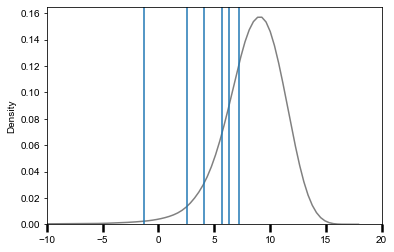

In [39]:
f, ax = plt.subplots()

sns.kdeplot(x = scores, ax = ax, color = 'grey', bw_adjust = 3)

ax.axvline(7.22) # space acceptor MaxEnt score
ax.axvline(6.32) # PRE acceptor MaxEnt score
ax.axvline(5.66) # Blank acceptor MaxEnt score
ax.axvline(4.08) # SRE2 acceptor MaxEnt score
ax.axvline(2.56) # SRE1 acceptor MaxEnt score
ax.axvline(-1.33) # Let-7 acceptor MaxEnt score

ax.set_xlim(-10, 20)

#f.savefig('Figures_ver3/MAXENT_score_all_SD_transcriptome.pdf', transparent = True)

## Figure S2B: Single reporter validation

In [10]:
# western plot quantification
western = pd.read_excel(
    'data/single_reporter_validation_quantification.xlsx', 
    sheet_name = 'Westernblot'
)
western['1-f'] = western.groupby(['Replicate', 'RE'])['norm_exp'].apply(lambda g: g/g.sum())
western['f'] = 1 - western['1-f']
western['sample'] = 'protein'
protein = western[western['Isoform']=='FL']

# sequencing quantification
mRNA = hela[hela['isoform']=='full_length'].reset_index(drop = True)
mRNA['f'] = 1 - mRNA['fraction']
mRNA['sample'] = 'RNA'

Text(0, 0.5, 'splicing efficiency')

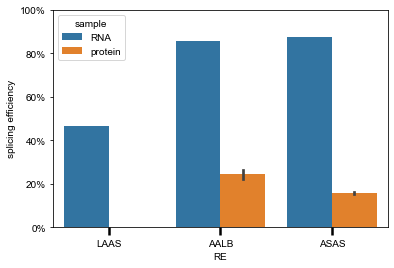

In [12]:
toplot = pd.concat([mRNA[['RE', 'f', 'sample']], protein[['RE', 'f', 'sample']]])

f, ax = plt.subplots()

sns.barplot(
    data = toplot, 
    x = 'RE', 
    y = 'f', 
    hue = 'sample', 
    order = ['LAAS', 'AALB', 'ASAS'],
    ax = ax
)

change_width(f, 0.1)


ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
ax.set_ylabel('splicing efficiency')

#f.savefig('Figures_ver3/Figure_S3_protein_mRNA_spliced_fraction.pdf', transparent = True)

## Figure S2C: donor usage

Text(0, 0.5, 'splicing efficiency')

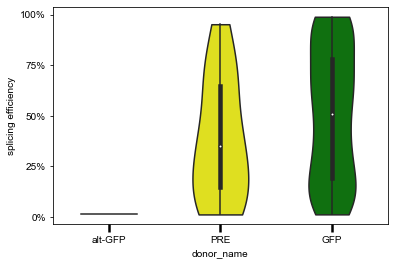

In [14]:
f, ax = plt.subplots()

toplot = hela[hela['fraction']>0.01]

sns.violinplot(
    data = toplot, 
    x = 'donor_name', 
    y = 'fraction', 
    order = ['alt-GFP', 'PRE', 'GFP'],
    palette = ['blue', 'yellow', 'green'],
    width = 0.5,
    cut = 0,
    ax = ax)

ax.set_yticks([0.0, 0.25, 0.50, 0.75, 1.0])
ax.set_yticklabels(['0%', '25%', '50%', '75%', '100%'])
ax.set_ylabel('splicing efficiency')

#f.savefig('Figures_ver3/Figure2_GFP_PRE_others_donor.pdf', transparent = True)

## Figure S3D: PRE vs GFP donor usage

/var/folders/ly/fgzs9d8s7txdbr22383tmh0c0000gr/T/ipykernel_2324/3026025510.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pre_reporter = toplot[


[Text(0, 0.0, '0%'), Text(0, 0.5, '50%'), Text(0, 1.0, '100%')]

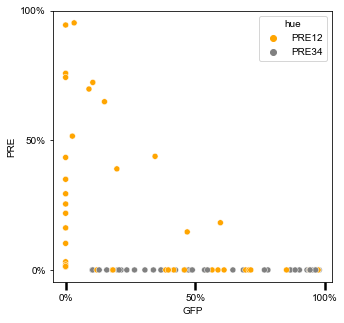

In [45]:
# filter for reporter with 1 or more PRE
pre_reporter = toplot[
    (hela['RE'].str.contains('p'))&
    (hela['RE'].str.contains('^[BLpSA]{4}$'))&
    (hela['fraction']>0)
]

# covert to wide dataframe
pre_reporter_wide = pd.pivot_table(
    pre_reporter, index = 'RE', values = 'fraction', columns = 'donor_name', fill_value = 0
).reset_index()

def make_hue(p):
    if 'p' not in p:
        return 'PRE0'
    elif p[0] == 'p' or p[1] == 'p':
        return 'PRE12'
    else:
        return 'PRE34'

# flag if PRE is in 1st/2nd position VS 3rd/4th position
pre_reporter_wide['hue'] = pre_reporter_wide.apply(lambda g: make_hue(g['RE']), axis = 1)

# scatterplot comparing PRE and GFP donor
f, ax = plt.subplots(figsize = (5, 5))

sns.scatterplot(
    data = pre_reporter_wide, 
    x = 'GFP', 
    y = 'PRE', 
    hue = 'hue', 
    hue_order = ['PRE12', 'PRE34'],
    palette = ['orange', 'grey'],
    ax = ax
)

ax.set_xticks([0, 0.5, 1.0])
ax.set_xticklabels(['0%', '50%', '100%'])
ax.set_yticks([0, 0.5, 1.0])
ax.set_yticklabels(['0%', '50%', '100%'])

#f.savefig('Figures_ver3/Figure_2_scatterplot_PRE_GFP.pdf')

## Figure S3E: acceptor usage

Text(0, 0.5, 'splicing efficiency')

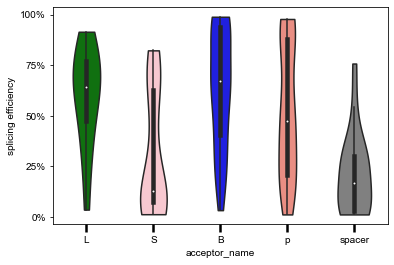

In [15]:
f, ax = plt.subplots()

sns.violinplot(
    data = toplot, 
    x = 'acceptor_name', 
    y = 'fraction', 
    order = ['L', 'S', 'B', 'p', 'spacer'],
    palette = ['green', 'pink', 'blue', 'salmon', 'grey'],
    width = 0.5,
    cut = 0,
    ax = ax)


ax.set_yticks([0.0, 0.25, 0.50, 0.75, 1.0])
ax.set_yticklabels(['0%', '25%', '50%', '75%', '100%'])
ax.set_ylabel('splicing efficiency')

#f.savefig('Figures_ver3/Figure_3_acceptor_usage_by_RE.pdf', transparent = True)

## Figure S2F: distribution of intron length

In [50]:
HELA = pd.read_csv('ptreseq_splicing_quantification/HELA_2rep_fraction.txt', sep = '\t')
HELA_long = pd.melt(HELA, id_vars = ['RE'], value_vars = HELA.columns[1:-3], var_name = 'isoform', value_name = 'fraction')
HELA_long = HELA_long[HELA_long['fraction']!=0]

def intron_length(c):
    if c == 'full_length':
        return np.nan
    else:
        _, start, _, end = c.split('_')
        return int(end) - int(start) + 1
    
HELA_long['intron_len'] = HELA_long['isoform'].apply(lambda g: intron_length(g))

(0.0, 200.0)

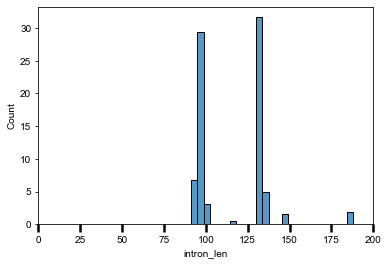

In [51]:
f, ax = plt.subplots()

sns.histplot(
    data = HELA_long, 
    x = 'intron_len',
    weights = 'fraction', 
    stat = 'count',
    bins = 25, 
    ax = ax
)

ax.set_xlim(0, 200)

#f.savefig('Figures_ver3/Figure_3/Histogram_intron_length.pdf', transparent = True)